In [1]:
import os, sys 
import h5py
import numpy as np
import corner as DFM
# -- galpopfm --
from galpopfm.catalogs import Catalog
from galpopfm import dustfm as dustFM
from galpopfm import dust_infer as dustInfer
from galpopfm import measure_obs as measureObs
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
thetas_eagle = np.loadtxt(os.path.join(os.environ['GALPOPFM_DIR'], 'abc',
                                  'eagle.slab_noll_mssfr_fixbump.L2_only.3d', 
                                  'theta.t19.dat')) 
theta_eagle = np.median(thetas_eagle, axis=0) 

thetas_tng = np.loadtxt(os.path.join(os.environ['GALPOPFM_DIR'], 'abc',
                                  'tng.slab_noll_mssfr_fixbump.L2_only.3d', 
                                  'theta.t19.dat')) 
theta_tng = np.median(thetas_tng, axis=0) 

In [3]:
sdss = Catalog('tinker') 
sdss_M_fuv, sdss_M_nuv, _, sdss_M_g, sdss_M_r, _, _ = sdss.data['NSA_ABSMAG'].T
mr_complete = (sdss_M_r < -20.) 

x_obs = [-1.*sdss_M_r[mr_complete], 
        sdss_M_g[mr_complete] - sdss_M_r[mr_complete], 
        sdss_M_fuv[mr_complete] - sdss_M_nuv[mr_complete]] 
sfr0_obs = np.zeros(len(x_obs[0])).astype(bool)

In [4]:
def dustfm_sfr0_adhoc(sim, theta): 
    _sim_sed = dustInfer._read_sed(sim) 
    wlim = (_sim_sed['wave'] > 1e3) & (_sim_sed['wave'] < 8e3) 
    
    mlim    = (_sim_sed['logmstar'] > 9.4) 
    zerosfr = (_sim_sed['logsfr.inst'] == -999)

    cuts = mlim 
    
    sim_sed = {} 
    sim_sed['sim']          = sim 
    sim_sed['logmstar']     = _sim_sed['logmstar'][cuts].copy()
    sim_sed['logsfr.inst']  = _sim_sed['logsfr.inst'][cuts].copy() 
    sim_sed['wave']         = _sim_sed['wave'][wlim].copy()
    sim_sed['sed_noneb']    = _sim_sed['sed_noneb'][cuts,:][:,wlim].copy() 
    sim_sed['sed_onlyneb']  = _sim_sed['sed_onlyneb'][cuts,:][:,wlim].copy() 
    

    zerosfr_obs = dustInfer._observable_zeroSFR(
            _sim_sed['wave'][wlim], 
            _sim_sed['sed_neb'][cuts & zerosfr,:][:,wlim])

    x_mod = dustInfer.sumstat_model(theta, sed=sim_sed,
            dem='slab_noll_mssfr_fixbump', 
            f_downsample=1., statistic='2d', noise=True, 
            extra_data=zerosfr_obs, return_datavector=True)
    _zerosfr = np.zeros(x_mod.shape[1]).astype(bool)
    _zerosfr[np.sum(cuts):] = True
    
    return x_mod, _zerosfr

In [5]:
def dustfm_sfr0_sfrmin(sim, theta): 
    ''' assign SFR_min to SFR=0 galaxies
    '''
    _sim_sed = dustInfer._read_sed(sim) 
    wlim = (_sim_sed['wave'] > 1e3) & (_sim_sed['wave'] < 8e3) 
    
    # SFR = 0 galaxies
    zerosfr = (_sim_sed['logsfr.inst'] == -999)
    logsfr_min = _sim_sed['logsfr.inst'][~zerosfr].min() # minimum SFR
    _sim_sed['logsfr.inst'][zerosfr] = logsfr_min
    
    cuts = (_sim_sed['logmstar'] > 9.4) 
    
    sim_sed = {} 
    sim_sed['sim']          = sim 
    sim_sed['logmstar']     = _sim_sed['logmstar'][cuts].copy()
    sim_sed['logsfr.inst']  = _sim_sed['logsfr.inst'][cuts].copy() 
    sim_sed['wave']         = _sim_sed['wave'][wlim].copy()
    sim_sed['sed_noneb']    = _sim_sed['sed_noneb'][cuts,:][:,wlim].copy() 
    sim_sed['sed_onlyneb']  = _sim_sed['sed_onlyneb'][cuts,:][:,wlim].copy() 
    

    x_mod = dustInfer.sumstat_model(theta, sed=sim_sed,
            dem='slab_noll_mssfr_fixbump', 
            f_downsample=1., statistic='2d', noise=True, 
            extra_data=None, return_datavector=True)    
    return x_mod, zerosfr[cuts]

In [6]:
def dustfm_sfr0_sampledsfr(sim, theta): 
    ''' assign SFR_min to SFR=0 galaxies
    '''
    _sim_sed = dustInfer._read_sed(sim) 
    wlim = (_sim_sed['wave'] > 1e3) & (_sim_sed['wave'] < 8e3) 
    
    # SFR = 0 galaxies
    zerosfr = (_sim_sed['logsfr.inst'] == -999)
    sfr_min = 10**(_sim_sed['logsfr.inst'][~zerosfr].min()) # minimum SFR
    _sim_sed['logsfr.inst'][zerosfr] = np.log10(np.random.uniform(np.sum(zerosfr)) * sfr_min)
    
    cuts = (_sim_sed['logmstar'] > 9.4) 
    
    sim_sed = {} 
    sim_sed['sim']          = sim 
    sim_sed['logmstar']     = _sim_sed['logmstar'][cuts].copy()
    sim_sed['logsfr.inst']  = _sim_sed['logsfr.inst'][cuts].copy() 
    sim_sed['wave']         = _sim_sed['wave'][wlim].copy()
    sim_sed['sed_noneb']    = _sim_sed['sed_noneb'][cuts,:][:,wlim].copy() 
    sim_sed['sed_onlyneb']  = _sim_sed['sed_onlyneb'][cuts,:][:,wlim].copy() 

    x_mod = dustInfer.sumstat_model(theta, sed=sim_sed,
            dem='slab_noll_mssfr_fixbump', 
            f_downsample=1., statistic='2d', noise=True, 
            extra_data=None, return_datavector=True)    
    return x_mod, zerosfr[cuts]

[20.90316578 20.90210515 20.70605262 ... 18.35124198 18.40677011
 18.60083971]
[0.81 0.79 0.81 ... 1.05 0.79 0.87]
[1.55 1.13 1.55 ... 3.59 1.13 1.85]
[18.01625169 18.35963403 17.53323438 ... 16.50247161 16.55889928
 16.70412372]
[-0.06284821 -0.00031109 -0.19035303 ...  0.30160958  0.30412972
  0.29175233]
[2.47747156 2.32100945 2.464439   ... 2.69406838 2.96248304 3.04992186]
[20.17803035 20.53904255 20.21133273 ... 18.34993539 18.37653295
 18.61265342]
[1.11782387 0.93949092 0.91788693 ... 0.66329742 0.67302401 0.68424164]
[4.46598378 3.55716564 4.09788551 ... 3.08698941 3.09402357 3.05187122]


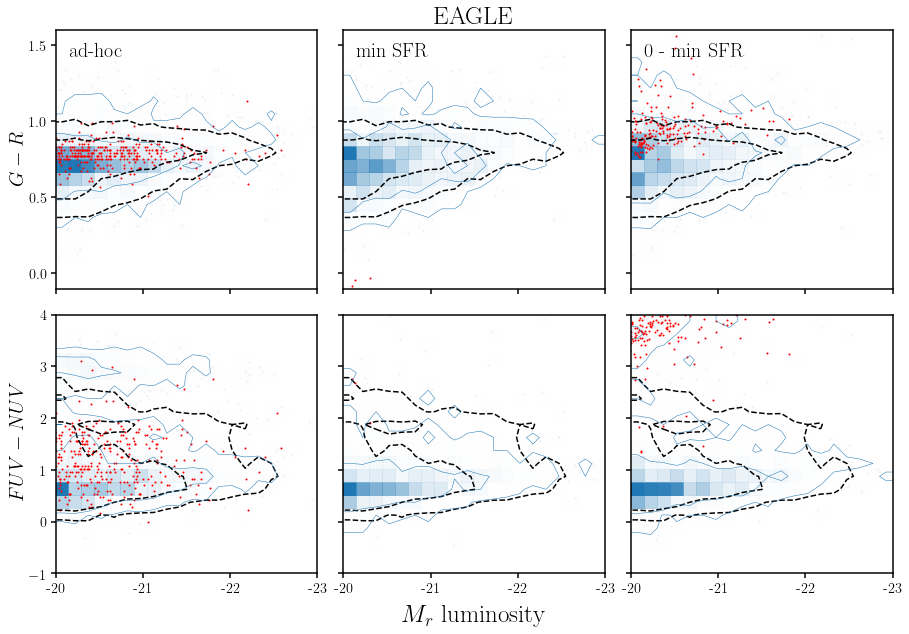

In [7]:
fig = plt.figure(figsize=(15,10))

for i, dustfm in enumerate([dustfm_sfr0_adhoc, dustfm_sfr0_sfrmin, dustfm_sfr0_sampledsfr]): 
    _x, _sfr0 = dustfm('eagle', theta_eagle)

    # R vs (G - R)
    sub = fig.add_subplot(2,3,i+1)
    DFM.hist2d(x_obs[0], x_obs[1], levels=[0.68, 0.95],
               range=[(20, 23), (-0.1, 1.6)], bins=20, color='k', 
               contour_kwargs={'linestyles': 'dashed'}, 
               plot_datapoints=False, fill_contours=False, plot_density=False, ax=sub)
    DFM.hist2d(_x[0], _x[1], levels=[0.68, 0.95],
            range=[(20, 23), (-0.1, 1.6)], bins=20, color='C0', 
            contour_kwargs={'linewidths': 0.5}, 
            plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub)
    print(_x[0][_sfr0])
    print(_x[1][_sfr0])
    sub.scatter(_x[0][_sfr0], _x[1][_sfr0], c='r', s=1)
    sub.set_xlim(20., 23) 
    sub.set_xticks([20., 21., 22., 23]) 
    sub.set_xticklabels([])
    if i == 0: sub.text(0.05, 0.95, 'ad-hoc', transform=sub.transAxes, ha='left', va='top', fontsize=20)
    elif i == 1: sub.text(0.05, 0.95, 'min SFR', transform=sub.transAxes, ha='left', va='top', fontsize=20)
    elif i == 2: sub.text(0.05, 0.95, '0 - min SFR', transform=sub.transAxes, ha='left', va='top', fontsize=20)

    if i == 0: 
        sub.set_ylabel(r'$G-R$', fontsize=20) 
    else: 
        sub.set_yticklabels([]) 
    sub.set_ylim((-0.1, 1.6)) 
    sub.set_yticks([0., 0.5, 1., 1.5])

    # R vs FUV-NUV
    sub = fig.add_subplot(2,3,i+4)
    DFM.hist2d(x_obs[0], x_obs[2], levels=[0.68, 0.95],
        range=[(20, 23), (-1, 4)], bins=20, color='k', 
        contour_kwargs={'linestyles': 'dashed'}, 
        plot_datapoints=False, fill_contours=False, plot_density=False, ax=sub)
    DFM.hist2d(_x[0], _x[2], levels=[0.68, 0.95],
            range=[(20, 23), (-1, 4)], bins=20, color='C0', 
            contour_kwargs={'linewidths': 0.5}, 
            plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub) 
    print(_x[2][_sfr0])
    sub.scatter(_x[0][_sfr0], _x[2][_sfr0], c='r', s=1)
    sub.set_xlim(20., 23) 
    sub.set_xticks([20., 21., 22., 23]) 
    sub.set_xticklabels([-20, -21, -22, -23]) 
    if i == 0: 
        sub.set_ylabel(r'$FUV - NUV$', fontsize=20) 
    else: 
        sub.set_yticklabels([]) 
    sub.set_ylim((-1, 4)) 

bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel(r'$M_r$ luminosity', labelpad=10, fontsize=25) 
bkgd.set_title('EAGLE', fontsize=25)
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

[22.25896092 22.35053244 22.37081305 ... 18.25903515 18.12912771
 17.6892726 ]
[0.81 0.71 0.69 ... 0.79 0.79 0.81]
[1.49 0.65 0.53 ... 1.25 1.19 1.49]
[22.26439109 22.39803656 22.33957384 ... 18.19117482 18.01994389
 17.62334548]
[0.7069918  0.80030405 0.73842815 ... 0.72004636 0.67260266 0.7572847 ]
[2.40305462 2.36257155 2.54093813 ... 3.02831263 2.97331184 2.79609128]
[21.56907593 21.69441385 21.70588973 ... 17.4761586  17.31857809
 16.81336719]
[0.95987864 1.03817619 0.95653594 ... 0.98780084 0.93842387 1.01952094]
[3.64406696 3.42779434 3.09888192 ... 3.60130622 3.77733198 3.63387114]


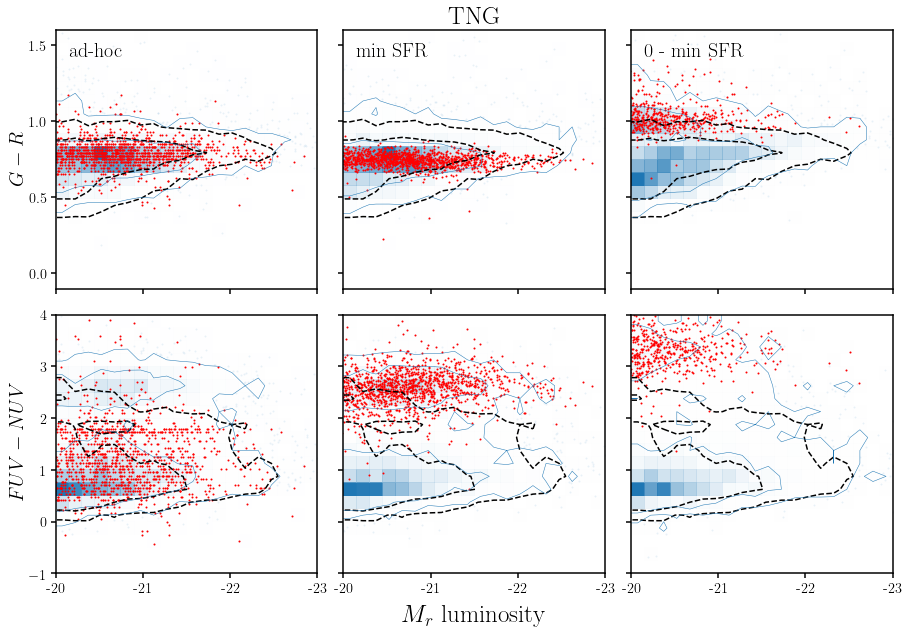

In [8]:
fig = plt.figure(figsize=(15,10))

for i, dustfm in enumerate([dustfm_sfr0_adhoc, dustfm_sfr0_sfrmin, dustfm_sfr0_sampledsfr]): 
    _x, _sfr0 = dustfm('tng', theta_tng)

    # R vs (G - R)
    sub = fig.add_subplot(2,3,i+1)
    DFM.hist2d(x_obs[0], x_obs[1], levels=[0.68, 0.95],
               range=[(20, 23), (-0.1, 1.6)], bins=20, color='k', 
               contour_kwargs={'linestyles': 'dashed'}, 
               plot_datapoints=False, fill_contours=False, plot_density=False, ax=sub)
    DFM.hist2d(_x[0], _x[1], levels=[0.68, 0.95],
            range=[(20, 23), (-0.1, 1.6)], bins=20, color='C0', 
            contour_kwargs={'linewidths': 0.5}, 
            plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub)
    print(_x[0][_sfr0])
    print(_x[1][_sfr0])
    sub.scatter(_x[0][_sfr0], _x[1][_sfr0], c='r', s=1)
    if i == 0: sub.text(0.05, 0.95, 'ad-hoc', transform=sub.transAxes, ha='left', va='top', fontsize=20)
    elif i == 1: sub.text(0.05, 0.95, 'min SFR', transform=sub.transAxes, ha='left', va='top', fontsize=20)
    elif i == 2: sub.text(0.05, 0.95, '0 - min SFR', transform=sub.transAxes, ha='left', va='top', fontsize=20)
    sub.set_xlim(20., 23) 
    sub.set_xticks([20., 21., 22., 23]) 
    sub.set_xticklabels([])
    if i == 0: 
        sub.set_ylabel(r'$G-R$', fontsize=20) 
    else: 
        sub.set_yticklabels([]) 
    sub.set_ylim((-0.1, 1.6)) 
    sub.set_yticks([0., 0.5, 1., 1.5])

    # R vs FUV-NUV
    sub = fig.add_subplot(2,3,i+4)
    DFM.hist2d(x_obs[0], x_obs[2], levels=[0.68, 0.95],
        range=[(20, 23), (-1, 4)], bins=20, color='k', 
        contour_kwargs={'linestyles': 'dashed'}, 
        plot_datapoints=False, fill_contours=False, plot_density=False, ax=sub)
    DFM.hist2d(_x[0], _x[2], levels=[0.68, 0.95],
            range=[(20, 23), (-1, 4)], bins=20, color='C0', 
            contour_kwargs={'linewidths': 0.5}, 
            plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub) 
    print(_x[2][_sfr0])
    sub.scatter(_x[0][_sfr0], _x[2][_sfr0], c='r', s=1)
    sub.set_xlim(20., 23) 
    sub.set_xticks([20., 21., 22., 23]) 
    sub.set_xticklabels([-20, -21, -22, -23]) 
    if i == 0: 
        sub.set_ylabel(r'$FUV - NUV$', fontsize=20) 
    else: 
        sub.set_yticklabels([]) 
    sub.set_ylim((-1, 4)) 

bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_title('TNG', fontsize=25)
bkgd.set_xlabel(r'$M_r$ luminosity', labelpad=10, fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.1, hspace=0.1)